In [1]:
import os, torch, torchvision
from torch.nn import functional as F
from torchvision import transforms, datasets

In [2]:
import torch.utils

target_transforms = torchvision.transforms.Compose([
    lambda x:torch.tensor(x), # or just torch.tensor
    lambda x:F.one_hot(x,2)
])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=(0, 360)),
        transforms.RandomResizedCrop(256, scale=(0.5, 1), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        transforms.AutoAugment(policy=torchvision.transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=(0.3, 1), hue=(0.0, 0.5)),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
        transforms.RandomEqualize(),
        transforms.RandomGrayscale(p=0.2),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        transforms.AutoAugment(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x], target_transform=target_transforms)
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(image_datasets['train'], [30, 10])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names, device

(['cleaned', 'dirty'], device(type='cuda', index=0))

In [3]:
for x, y in dataloaders['train']:
    print(x.dtype)
    #print(y.max(axis=1)[1])

torch.float32


In [4]:
import matplotlib.pyplot as plt
import numpy as np

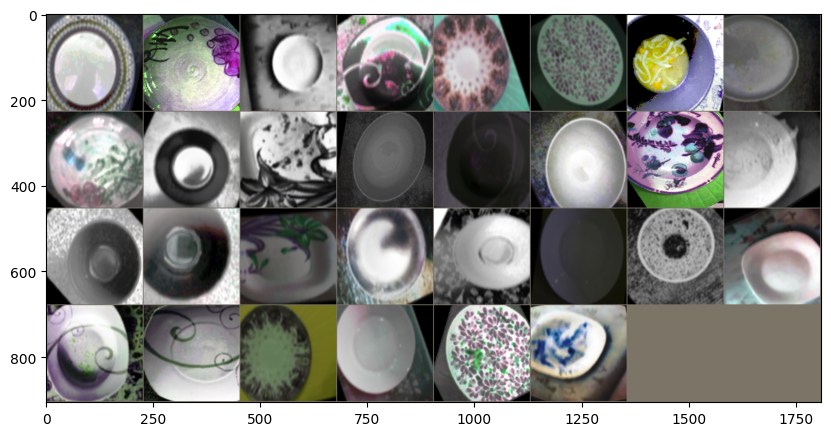

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp,)
    #if title is not None:
    #    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
classes = classes.max(axis=1)[1]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

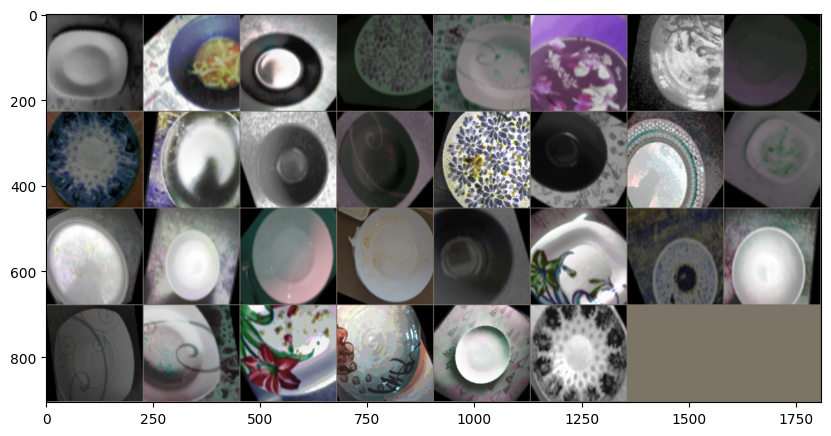

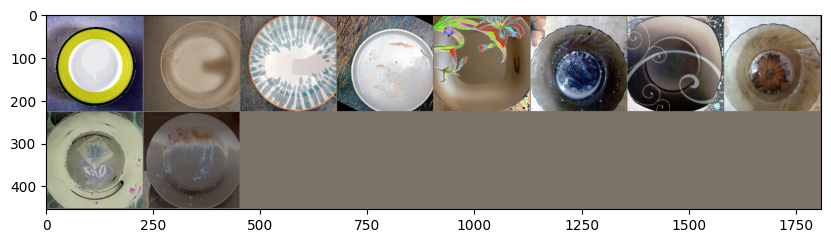

In [6]:
phases = ['train','val']
for phase in phases:
    for inputs, labels in dataloaders[phase]:
        # Get a batch of training data
        inputs, classes = next(iter(dataloaders[phase]))
        classes = classes.max(axis=1)[1]
        # Make a grid from batch
        out = torchvision.utils.make_grid(inputs)

        imshow(out, title=[class_names[x] for x in classes])

In [7]:
import time
from tempfile import TemporaryDirectory

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    model.train()
    since = time.time()
    losses = []
    accs = []
    val_losses = []
    val_accs = []
    norms = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']: # , 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels.float())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            
                    
                            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                            total_norm = 0
                            for param in model.parameters():
                                if param.grad is not None:
                                    param_norm = param.grad.detach().data.norm(2)
                                    total_norm += param_norm.item() ** 2
                            total_norm = total_norm ** 0.5
                            norms.append(total_norm)
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    labels = labels.max(axis=1)[1]
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    losses.append(epoch_loss)
                    accs.append(epoch_acc.item())
                elif phase == 'val':
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.item())
                    """
                    # Make a grid from batch
                    out = torchvision.utils.make_grid(inputs)

                    imshow(out.cpu(), title=[class_names[x] for x in labels])"""

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {scheduler.get_last_lr()[0]}')

                # deep copy the model
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, [losses, accs, val_losses, val_accs, norms]

In [9]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [10]:
from torch import nn, optim
from torchvision import models
from torch.optim import lr_scheduler

In [11]:
model_weights = models.VGG19_Weights.DEFAULT
model_ft = models.vgg19(weights=model_weights)

for param in model_ft.parameters():
    # param.requires_grad = False
    param.requires_grad = True
    
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [12]:
for param in model_ft.classifier.parameters():
    param.requires_grad = True
model_ft.classifier[-2] = nn.Dropout(p=0.5)
model_ft.classifier[-1] = nn.Linear(model_ft.classifier[-1].in_features, 2)    
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [13]:


# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
"""model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(model_ft.classifier[0].in_features, 2),
    nn.Softmax(dim=1)
)"""
"""model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(model_ft.fc.in_features, 200),
    nn.Linear(200, 2),
    nn.Softmax(dim=1)
)"""
# model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.9)


In [14]:
model_ft, [losses, accs, val_losses, val_accs, norms] = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.7374 Acc: 0.5000 LR: 0.01
val Loss: 0.7648 Acc: 0.4000 LR: 0.01
Epoch 1/99
----------
train Loss: 0.7671 Acc: 0.4000 LR: 0.01
val Loss: 0.7648 Acc: 0.4000 LR: 0.01
Epoch 2/99
----------
train Loss: 0.7501 Acc: 0.5667 LR: 0.01
val Loss: 0.7747 Acc: 0.3000 LR: 0.01
Epoch 3/99
----------
train Loss: 0.6550 Acc: 0.6000 LR: 0.01
val Loss: 0.7596 Acc: 0.2000 LR: 0.01
Epoch 4/99
----------
train Loss: 0.7156 Acc: 0.5667 LR: 0.01
val Loss: 0.7553 Acc: 0.2000 LR: 0.01
Epoch 5/99
----------
train Loss: 0.6950 Acc: 0.5667 LR: 0.01
val Loss: 0.6890 Acc: 0.4000 LR: 0.01
Epoch 6/99
----------
train Loss: 0.6889 Acc: 0.6667 LR: 0.01
val Loss: 0.6576 Acc: 0.4000 LR: 0.01
Epoch 7/99
----------
train Loss: 0.6201 Acc: 0.7000 LR: 0.01
val Loss: 0.6544 Acc: 0.5000 LR: 0.01
Epoch 8/99
----------
train Loss: 0.7055 Acc: 0.5333 LR: 0.01
val Loss: 0.7391 Acc: 0.4000 LR: 0.01
Epoch 9/99
----------
train Loss: 0.5622 Acc: 0.7000 LR: 0.01
val Loss: 0.6063 Acc: 0.7000 LR: 0.01


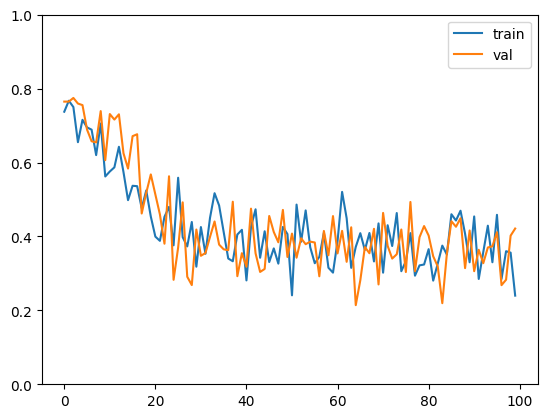

In [15]:
plt.plot(range(len(losses)), losses, label="train")
plt.plot(range(len(val_losses)), val_losses, label="val")

plt.ylim(0, 1)
plt.title = "loss"
plt.legend()
plt.show()

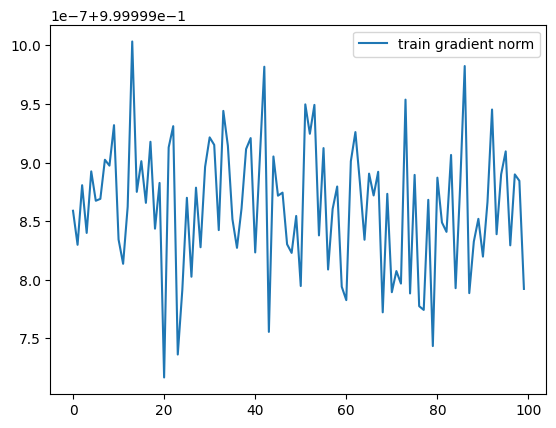

In [16]:
plt.plot(range(len(norms)), norms, label="train gradient norm")
plt.title = "train gradient norm"
plt.legend()
plt.show()

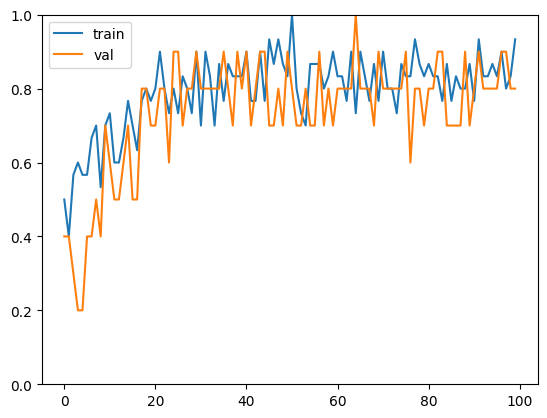

In [17]:
plt.plot(range(len(accs)), accs, label="train")
plt.plot(range(len(val_accs)), val_accs, label="val")
plt.ylim(0, 1)
plt.title = "accuracy"
plt.legend()
plt.show()

In [18]:
"""model_ft.eval()
visualize_model(model_ft)"""

'model_ft.eval()\nvisualize_model(model_ft)'

In [19]:
from PIL import Image
import pandas as pd

In [20]:
def to_csv(model, batch_size=10):
    model.eval()
    PATH_TEST = "data/test/"
    test_file_names = os.listdir(PATH_TEST)
    test_file_names.sort()

    submission_csv = {
        "id": [],
        "label": []
    }

    for file_name in test_file_names:
        id = file_name.split(".")[0]
        test_input = Image.open(os.path.join(PATH_TEST, file_name))
        test_input = data_transforms['test'](test_input).to(device).unsqueeze(0)
        with torch.no_grad():
            pred_test_label = model(test_input).max(1).indices.item()
            pred_test_label = class_names[pred_test_label]
        submission_csv['id'].append(id)
        submission_csv['label'].append(pred_test_label)

    submission_csv = pd.DataFrame(submission_csv).set_index("id")
    submission_csv.to_csv("submission.csv")

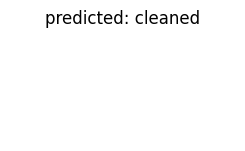

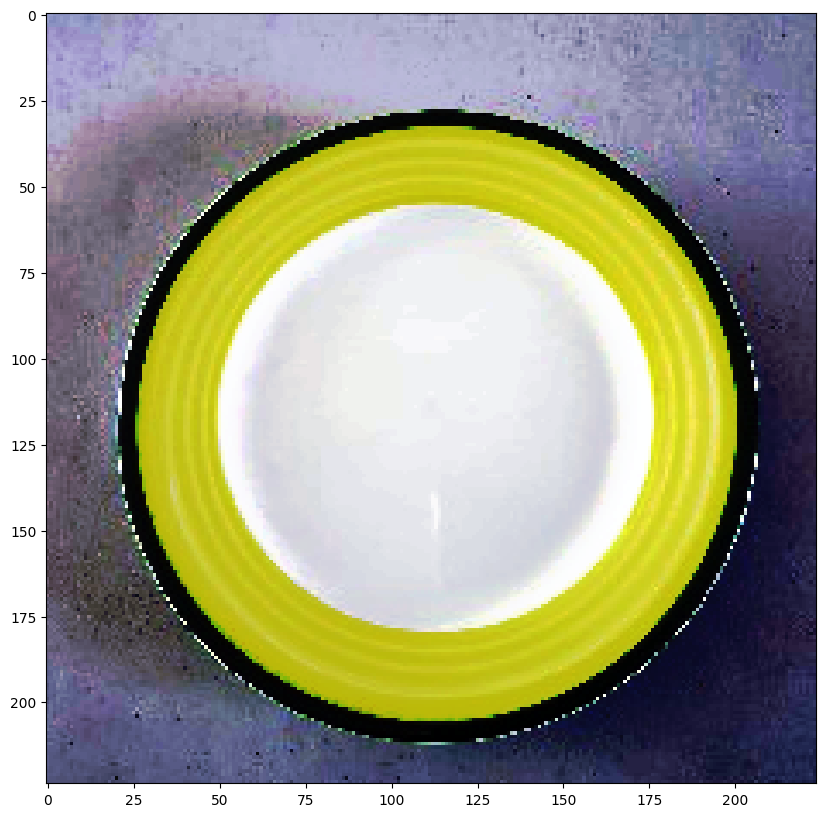

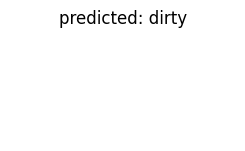

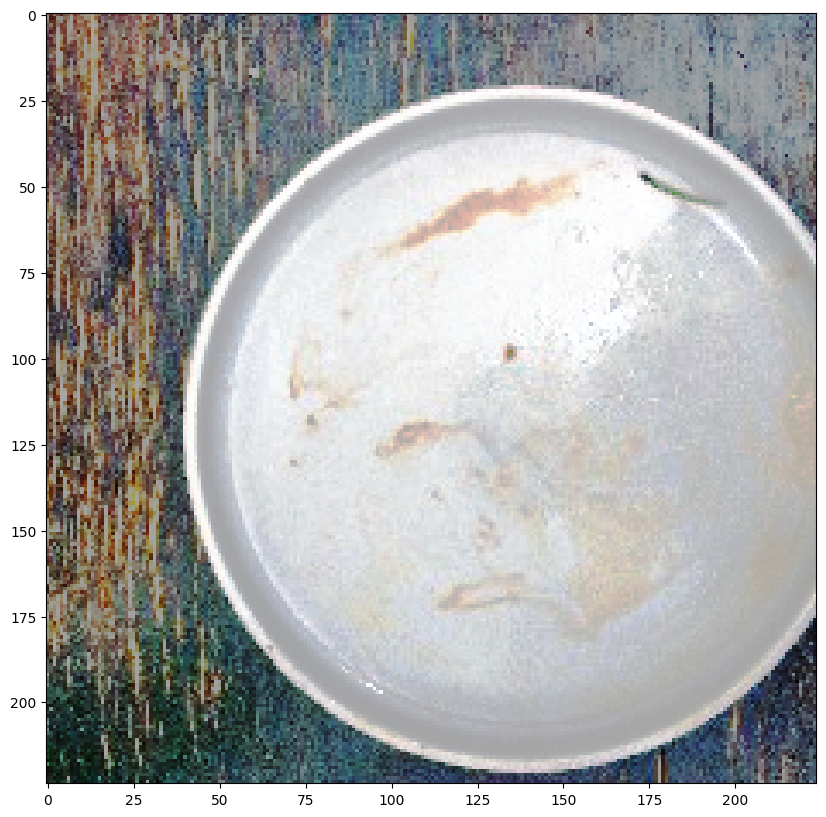

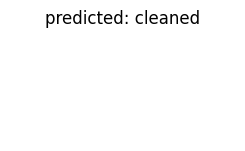

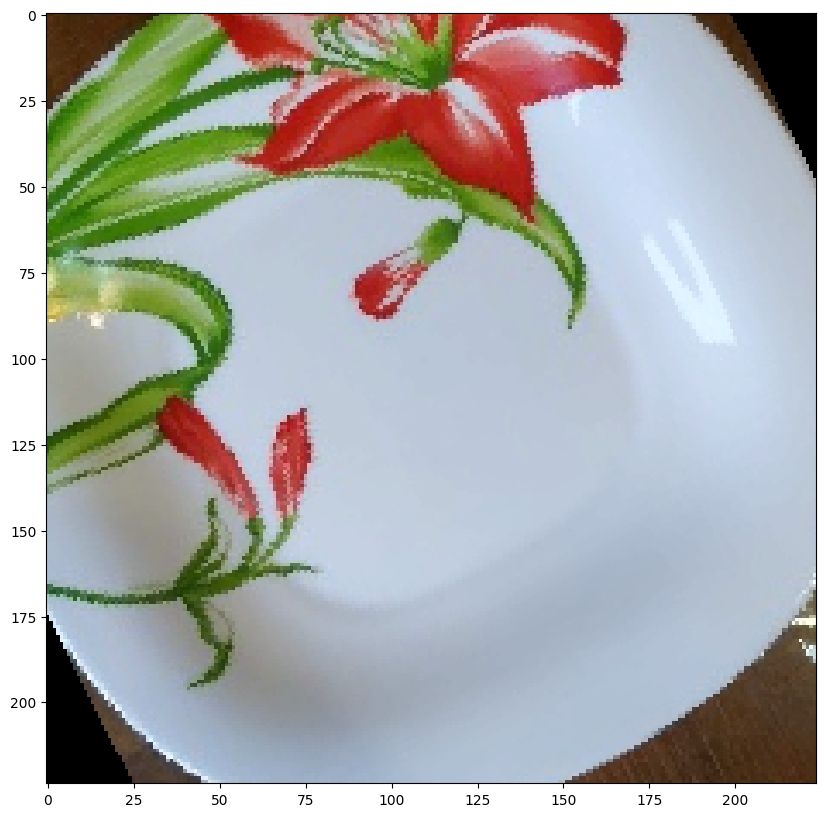

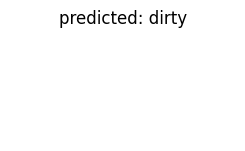

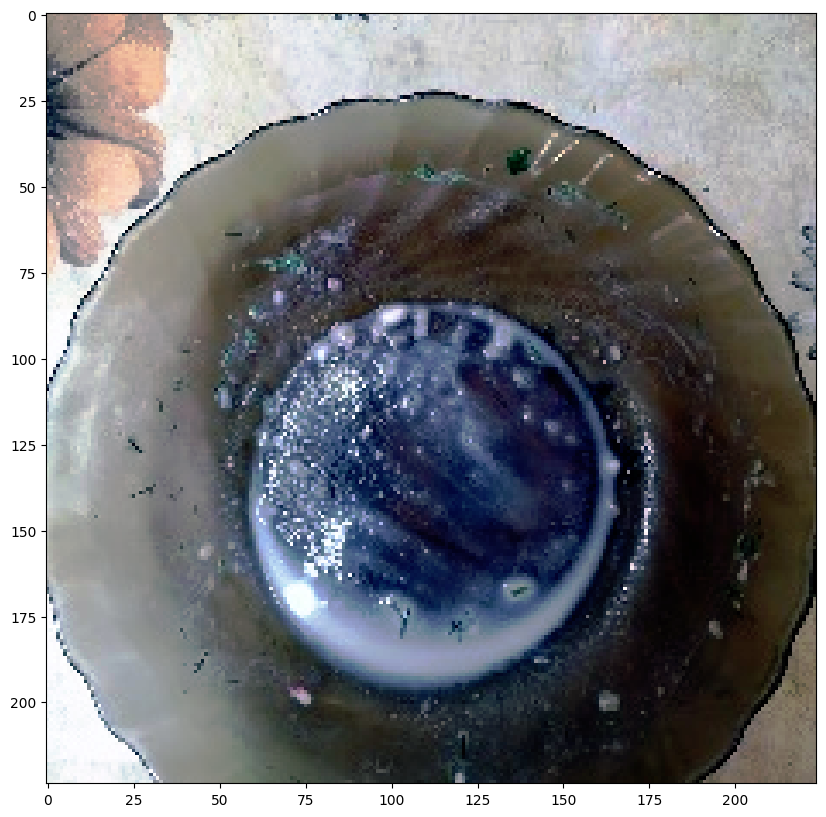

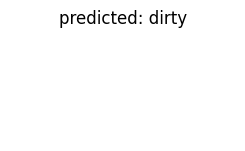

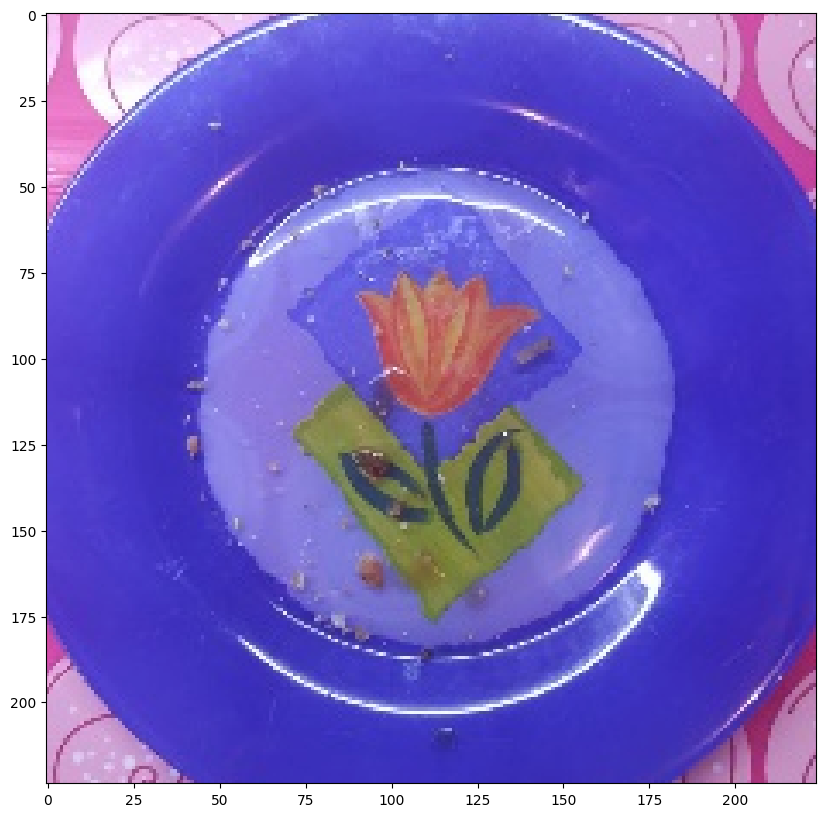

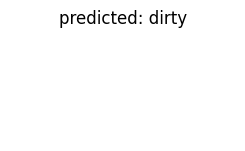

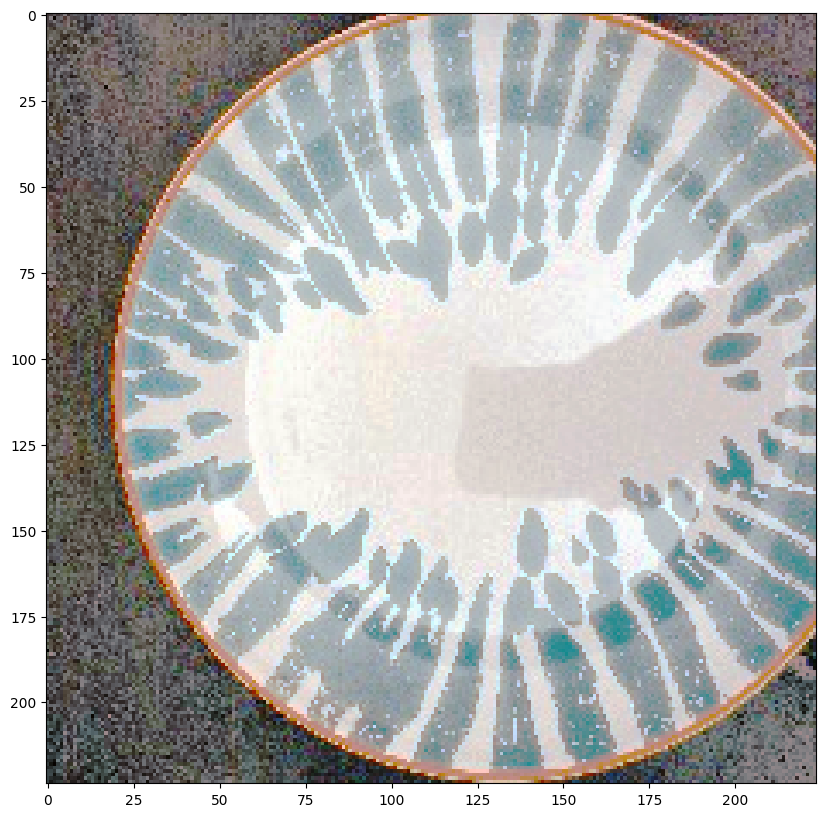

In [21]:
visualize_model(model_ft)

In [22]:
to_csv(model_ft)